# Static Analysis Tool Effectiveness

**Purpose**: Quantify the gap between what static analysis tools detect versus what actually causes exploits in production.

**Dataset Overview**:
- **Ground Truth Contracts**: 6 contracts (1 safe, 5 exploited)
  - Safe: Uniswap V4 PoolManager (manages billions in TVL)
  - Exploited: Sentiment ($1M), Parity ($30M), BeautyChain, Anubis ($60M), Private Bank
- **Slither Findings**: 298 findings across 6 contracts
- **Real-World Data**: 3,946 exploits from DeFi Rekt database ($89.9B in losses)

**Key Research Question**: Do static analysis tool priorities align with real-world vulnerability patterns?


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from pathlib import Path

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

def load_slither_parsed_json(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    findings_list = []
    for finding in data['analysis']['findings']:
        findings_list.append({
            'contract_name': data['contract'],
            'severity': finding['impact'],
            'check_type': finding['check'],
            'confidence': finding['confidence'],
            'description': finding['description']
        })
    return findings_list

parsed_dir = Path('static_analysis_results/json')
contracts_info = [
    ('anubis_ankh', 'exploited', 'Rugpull'),
    ('beautychain', 'exploited', 'Arithmetic'),
    ('parity_wallet_1', 'exploited', 'Access Control'),
    ('private_bank', 'exploited', 'Honeypot'),
    ('sentiment_pool_proxy', 'exploited', 'Reentrancy'),
    ('uniswap_v4_poolmanager', 'safe', None)
]

all_findings = []
for contract_name, status, vuln_type in contracts_info:
    filepath = parsed_dir / f"{contract_name}_slither_parsed.json"
    if filepath.exists():
        findings = load_slither_parsed_json(filepath)
        for f in findings:
            f['status'] = status
            f['actual_vuln'] = vuln_type
        all_findings.extend(findings)
    else:
        print(f"Warning: File not found: {filepath}")

slither_df = pd.DataFrame(all_findings)

defi_rekt_df = pd.read_csv('ecosystem_analysis/defirekt/defi_rekt_raw.csv')
vuln_landscape_df = defi_rekt_df.groupby('issueType').agg({
    'projectName': 'count',
    'fundsLost': 'sum'
}).reset_index()
vuln_landscape_df.columns = ['issueType', 'incident_count', 'total_loss']
vuln_landscape_df['incident_pct'] = (vuln_landscape_df['incident_count'] / len(defi_rekt_df) * 100)
vuln_landscape_df = vuln_landscape_df.sort_values('incident_count', ascending=False)

print(f"Loaded {len(slither_df)} Slither findings from 6 contracts")
print(f"Loaded {len(defi_rekt_df):,} real-world exploits (${vuln_landscape_df['total_loss'].sum()/1e9:.1f}B)")


Loaded 298 Slither findings from 6 contracts
Loaded 3,946 real-world exploits ($89.9B)


# Section 1: Slither Findings Analysis

Ground-truth validation using 6 contracts with known security outcomes.


In [15]:
contract_summary = slither_df.groupby(['contract_name', 'status', 'actual_vuln']).agg({
    'severity': 'count'
}).reset_index()
contract_summary.columns = ['contract', 'status', 'vulnerability', 'finding_count']

severity_breakdown = []
for contract in contract_summary['contract']:
    contract_findings = slither_df[slither_df['contract_name'] == contract]
    severity_counts = contract_findings['severity'].value_counts()
    severity_breakdown.append({
        'contract': contract,
        'High': severity_counts.get('High', 0),
        'Medium': severity_counts.get('Medium', 0),
        'Low': severity_counts.get('Low', 0),
        'Info': severity_counts.get('Informational', 0)
    })

severity_df = pd.DataFrame(severity_breakdown)
contract_summary = contract_summary.merge(severity_df, on='contract')
contract_summary = contract_summary.sort_values('finding_count', ascending=False)

print("=" * 100)
print("SLITHER FINDINGS: CONTRACT SUMMARY")
print("=" * 100)
print(contract_summary.to_string(index=False))
print(f"\nTotal: {len(slither_df)} findings across 6 contracts")

safe_count = slither_df[slither_df['status'] == 'safe'].shape[0]
exploited_count = slither_df[slither_df['status'] == 'exploited'].shape[0]
num_exploited_contracts = slither_df[slither_df['status'] == 'exploited']['contract_name'].nunique()
exploited_avg = exploited_count / num_exploited_contracts

print(f"\n{'='*100}")
print("KEY FINDING: THE FINDING VOLUME PARADOX")
print(f"{'='*100}")
print(f"Uniswap (safe, manages billions): {safe_count} findings")
print(f"All exploited contracts combined:  {exploited_count} findings")
print(f"Exploited average per contract:    {exploited_avg:.1f} findings ({num_exploited_contracts} contracts)")
print(f"\nRatio: Safe contract has {safe_count/exploited_avg:.1f}× MORE findings than exploited average")

SLITHER FINDINGS: CONTRACT SUMMARY
            contract    status  vulnerability  finding_count  High  Medium  Low  Info
     parity_wallet_1 exploited Access Control             82     3       3    5    62
         beautychain exploited     Arithmetic             27     0       0    0    22
        private_bank exploited       Honeypot             19     2       0    0    15
         anubis_ankh exploited        Rugpull             13     0       3    3     5
sentiment_pool_proxy exploited     Reentrancy             10     0       1    1     8

Total: 298 findings across 6 contracts

KEY FINDING: THE FINDING VOLUME PARADOX
Uniswap (safe, manages billions): 147 findings
All exploited contracts combined:  151 findings
Exploited average per contract:    30.2 findings (5 contracts)

Ratio: Safe contract has 4.9× MORE findings than exploited average


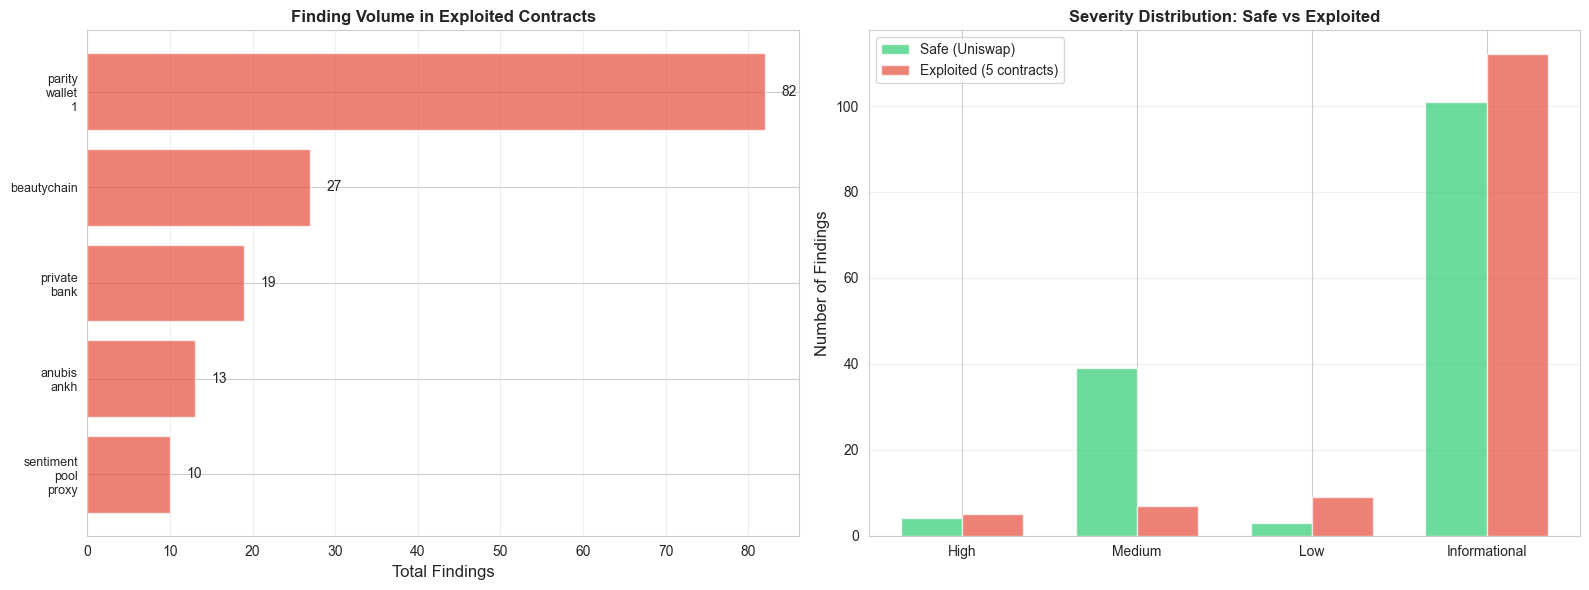


Key Insight:
  • Safe contract (Uniswap): 4 High findings
  • Exploited contracts (5 total): 5 High findings combined
  • Severity labels do not predict actual vulnerability


In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

contracts_sorted = contract_summary.sort_values('finding_count', ascending=True)
colors = ['#2ecc71' if s == 'safe' else '#e74c3c' for s in contracts_sorted['status']]
ax1.barh(range(len(contracts_sorted)), contracts_sorted['finding_count'], color=colors, alpha=0.7)
ax1.set_yticks(range(len(contracts_sorted)))
ax1.set_yticklabels([c.replace('_', '\n') for c in contracts_sorted['contract']], fontsize=9)
ax1.set_xlabel('Total Findings', fontsize=12)
ax1.set_title('Finding Volume in Exploited Contracts', fontweight='bold', fontsize=12)
ax1.grid(axis='x', alpha=0.3)
for i, count in enumerate(contracts_sorted['finding_count']):
    ax1.text(count + 2, i, str(count), va='center', fontsize=10)

safe_severity = slither_df[slither_df['status'] == 'safe']['severity'].value_counts()
exploited_severity = slither_df[slither_df['status'] == 'exploited']['severity'].value_counts()

severities = ['High', 'Medium', 'Low', 'Informational']
safe_counts = [safe_severity.get(s, 0) for s in severities]
exploited_counts = [exploited_severity.get(s, 0) for s in severities]

x = np.arange(len(severities))
width = 0.35
ax2.bar(x - width/2, safe_counts, width, label='Safe (Uniswap)', color='#2ecc71', alpha=0.7)
ax2.bar(x + width/2, exploited_counts, width, label=f'Exploited ({num_exploited_contracts} contracts)', color='#e74c3c', alpha=0.7)
ax2.set_xticks(x)
ax2.set_xticklabels(severities, rotation=0)
ax2.set_ylabel('Number of Findings', fontsize=12)
ax2.set_title('Severity Distribution: Safe vs Exploited', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nKey Insight:")
print(f"  • Safe contract (Uniswap): {safe_counts[0]} High findings")
print(f"  • Exploited contracts ({num_exploited_contracts} total): {exploited_counts[0]} High findings combined")
print(f"  • Severity labels do not predict actual vulnerability")


# Section 2: Real-World Vulnerability Landscape

Analysis of 3,946 actual exploits to understand what threats exist in production.


TOP 10 REAL-WORLD VULNERABILITY TYPES

Type                 Incidents    % of Total   Total Loss      Avg Loss
----------------------------------------------------------------------------------------------------
Honeypot              1,893          48.0%      $  0.01B        $   0.0M
Rugpull               1,065          27.0%      $ 16.05B        $  15.1M
Other                   495          12.5%      $ 64.49B        $ 130.3M
Access Control          239           6.1%      $  7.13B        $  29.8M
Flash Loan Attack       131           3.3%      $  0.98B        $   7.5M
Phishing                 50           1.3%      $  0.64B        $  12.9M
Oracle Issue             27           0.7%      $  0.39B        $  14.5M
Reentrancy               27           0.7%      $  0.23B        $   8.3M
Abandoned                18           0.5%      $  0.01B        $   0.3M

Total: 3,946 exploits | $89.9B in losses


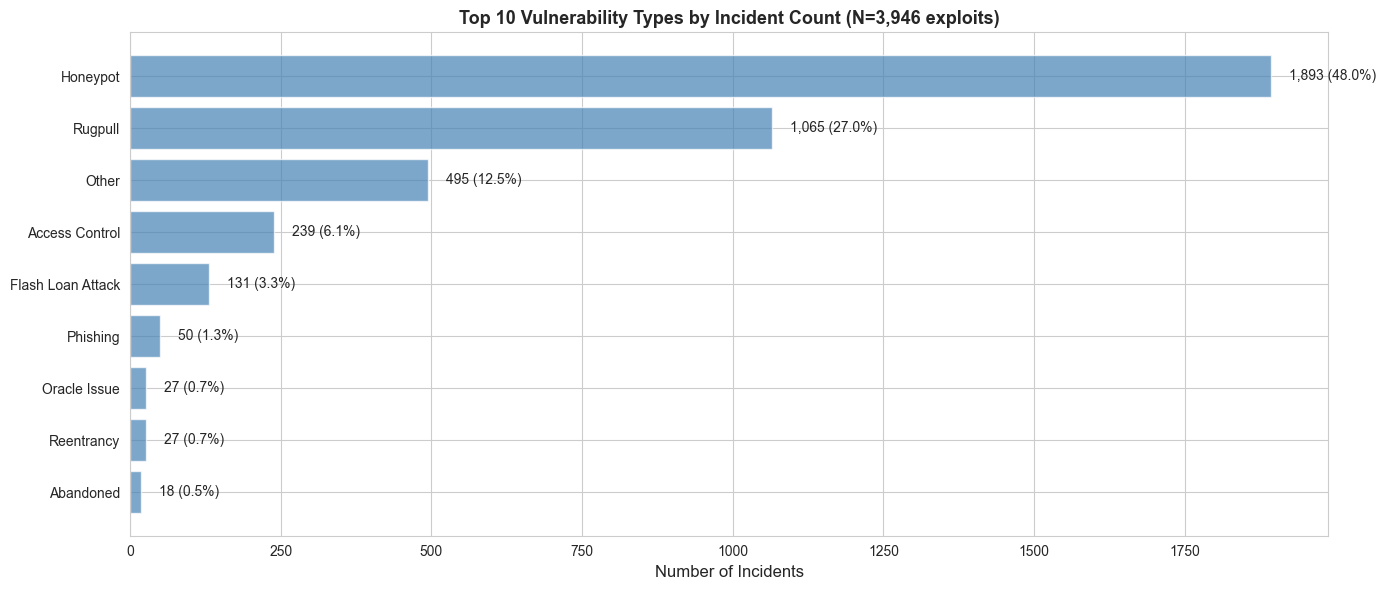

In [17]:
# A. Top 10 Vulnerability Types by Financial Impact
print("=" * 100)
print("TOP 10 REAL-WORLD VULNERABILITY TYPES")
print("=" * 100)
print(f"\n{'Type':<20} {'Incidents':<12} {'% of Total':<12} {'Total Loss':<15} {'Avg Loss'}")
print("-" * 100)

for _, row in vuln_landscape_df.head(10).iterrows():
    print(f"{row['issueType']:<20} {row['incident_count']:>6,}        "
          f"{row['incident_pct']:>6.1f}%      "
          f"${row['total_loss']/1e9:>6.2f}B        "
          f"${row['total_loss']/row['incident_count']/1e6:>6.1f}M")

print(f"\nTotal: {len(defi_rekt_df):,} exploits | ${vuln_landscape_df['total_loss'].sum()/1e9:.1f}B in losses")

fig, ax = plt.subplots(figsize=(14, 6))
top_10 = vuln_landscape_df.head(10)
ax.barh(range(len(top_10)), top_10['incident_count'], color='steelblue', alpha=0.7)
ax.set_yticks(range(len(top_10)))
ax.set_yticklabels(top_10['issueType'])
ax.set_xlabel('Number of Incidents', fontsize=12)
ax.set_title(f'Top 10 Vulnerability Types by Incident Count (N={len(defi_rekt_df):,} exploits)', fontweight='bold', fontsize=13)
ax.invert_yaxis()
for i, (count, pct) in enumerate(zip(top_10['incident_count'], top_10['incident_pct'])):
    ax.text(count + 30, i, f"{count:,} ({pct:.1f}%)", va='center', fontsize=10)
plt.tight_layout()
plt.show()


In [18]:
detectability = {
    'Reentrancy': {
        'category': 'Detectable',
        'static_tool_detection_possible': True,
        'citation': 'Veridise, "Detecting smart contract vulnerabilities with static analysis", 2025'
    },
    'Access Control': {
        'category': 'Partially Detectable',
        'static_tool_detection_possible': True,
        'citation': 'Slither Detector Documentation, crytic/slither, 2025'
    },
    'Oracle Issue': {
        'category': 'Partially Detectable',
        'static_tool_detection_possible': True,
        'citation': 'Veridise, "Detecting smart contract vulnerabilities with static analysis", 2025'
    },
    'Flash Loan Attack': {
        'category': 'Partially Detectable',
        'static_tool_detection_possible': True,
        'citation': 'Veridise, "Detecting smart contract vulnerabilities with static analysis", 2025'
    },
    'Rugpull': {
        'category': 'Partially Detectable',
        'static_tool_detection_possible': False,
        'citation': 'Mazorra et al., "Do Not Rug on Me", Mathematics 10(6):949, 2022'
    },
    'Honeypot': {
        'category': 'Partially Detectable',
        'static_tool_detection_possible': True,
        'citation': 'Torres et al., "The Art of The Scam", 2019'
    },
    'Phishing': {
        'category': 'Undetectable',
        'static_tool_detection_possible': False,
        'citation': 'Darktrace, "Crypto Wallets Continue to be Drained", 2025'
    },
    'Other': {
        'category': 'Heterogeneous',
        'static_tool_detection_possible': 'Varies',
        'citation': 'Veridise, "Detecting smart contract vulnerabilities with static analysis", 2025'
    },
    'Abandoned': {
        'category': 'Undetectable',
        'static_tool_detection_possible': False,
        'citation': 'Mazorra et al., "Do Not Rug on Me", Mathematics 10(6):949, 2022'
    },
    'Arithmetic': {
        'category': 'Detectable',
        'static_tool_detection_possible': True,
        'citation': 'Veridise, "Detecting smart contract vulnerabilities with static analysis", 2025'
    }
}

vuln_landscape_df['detectability'] = vuln_landscape_df['issueType'].map(
    lambda x: detectability.get(x, {}).get('category', 'Unknown')
)

print("\n" + "=" * 100)
print("DETECTABILITY FRAMEWORK")
print("=" * 100)
print(f"\n{'Category':<25} {'Type':<20} {'Incidents':<12} {'% Total':<10} {'Static Tool Capable'}")
print("-" * 100)

for category in ['Detectable', 'Partially Detectable', 'Heterogeneous', 'Undetectable']:
    category_vulns = vuln_landscape_df[vuln_landscape_df['detectability'] == category]
    if len(category_vulns) > 0:
        print(f"\n{category.upper()}:")
        for _, row in category_vulns.iterrows():
            static_capable = detectability.get(row['issueType'], {}).get('static_tool_detection_possible', 'Unknown')
            print(f"{'':25} {row['issueType']:<20} {row['incident_count']:>6,}        "
                  f"{row['incident_pct']:>5.1f}%     {str(static_capable)}")



DETECTABILITY FRAMEWORK

Category                  Type                 Incidents    % Total    Static Tool Capable
----------------------------------------------------------------------------------------------------

DETECTABLE:
                          Reentrancy               27          0.7%     True

PARTIALLY DETECTABLE:
                          Honeypot              1,893         48.0%     True
                          Rugpull               1,065         27.0%     False
                          Access Control          239          6.1%     True
                          Flash Loan Attack       131          3.3%     True
                          Oracle Issue             27          0.7%     True

HETEROGENEOUS:
                          Other                   495         12.5%     Varies

UNDETECTABLE:
                          Phishing                 50          1.3%     False
                          Abandoned                18          0.5%     False


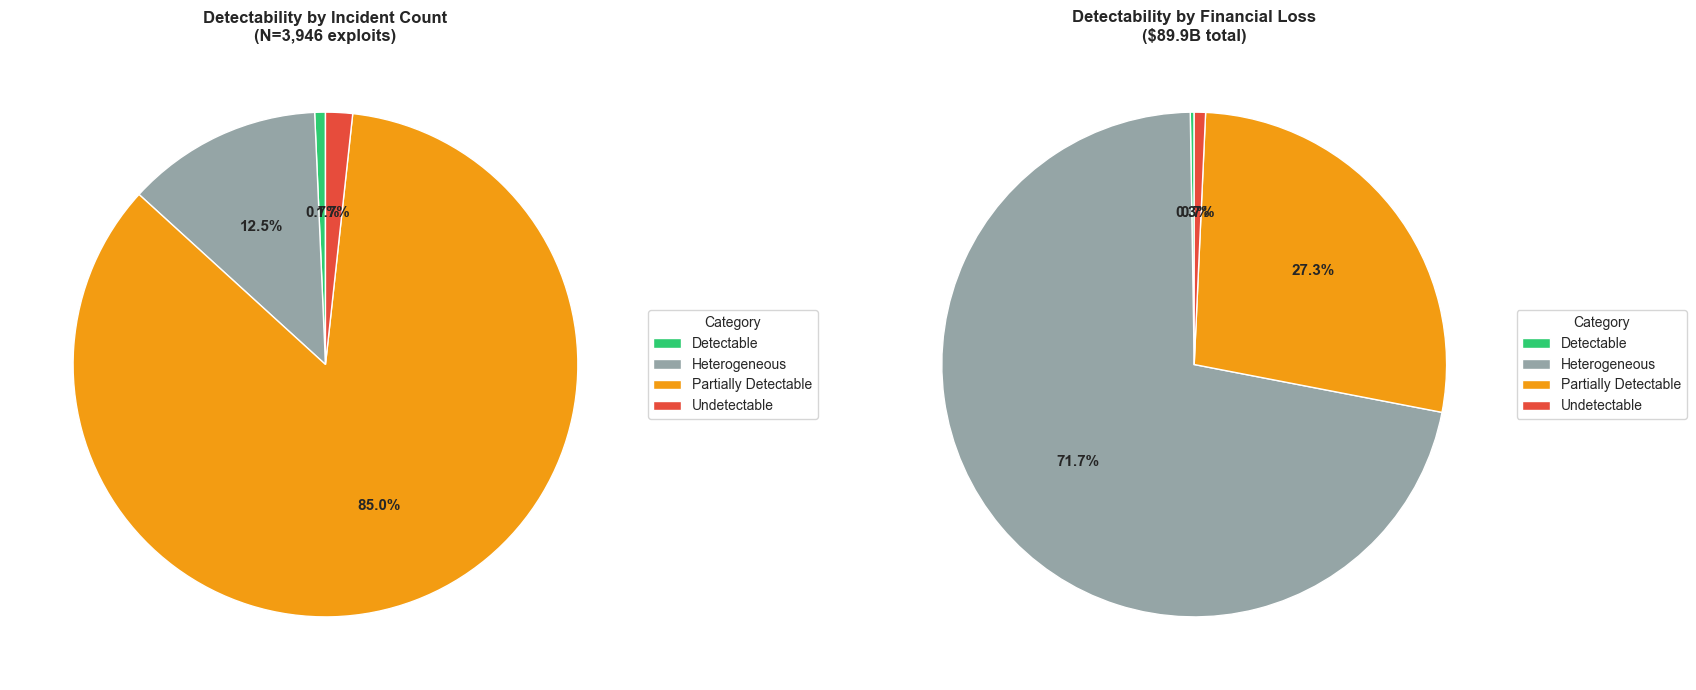


Key Finding:
  • Partially Detectable: 85.0% of incidents (Honeypot, Rugpull, Access Control)
  • Undetectable: 1.7% of incidents (Phishing, Abandoned)
  • Combined: 86.7% require specialized or ML-based detection
  • Financial impact: 28.0% of total losses ($25.2B)


In [19]:
detect_summary = vuln_landscape_df.groupby('detectability').agg({
    'incident_count': 'sum',
    'total_loss': 'sum'
}).reset_index()
detect_summary['incident_pct'] = detect_summary['incident_count'] / len(defi_rekt_df) * 100
detect_summary['loss_pct'] = detect_summary['total_loss'] / vuln_landscape_df['total_loss'].sum() * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

colors_detect = {'Detectable': '#2ecc71', 'Partially Detectable': '#f39c12',
                 'Heterogeneous': '#95a5a6', 'Undetectable': '#e74c3c'}
pie_colors = [colors_detect.get(cat, '#bdc3c7') for cat in detect_summary['detectability']]

wedges1, texts1, autotexts1 = ax1.pie(detect_summary['incident_count'],
                                       labels=None,  # Remove labels from pie
                                       autopct='%1.1f%%',
                                       colors=pie_colors,
                                       startangle=90,
                                       textprops={'fontsize': 11, 'weight': 'bold'})
ax1.set_title(f'Detectability by Incident Count\n(N={len(defi_rekt_df):,} exploits)', 
              fontweight='bold', fontsize=12)
ax1.legend(wedges1, detect_summary['detectability'], 
          title="Category", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=10)

wedges2, texts2, autotexts2 = ax2.pie(detect_summary['total_loss'],
                                       labels=None,  # Remove labels from pie
                                       autopct='%1.1f%%',
                                       colors=pie_colors,
                                       startangle=90,
                                       textprops={'fontsize': 11, 'weight': 'bold'})
ax2.set_title(f'Detectability by Financial Loss\n(${vuln_landscape_df["total_loss"].sum()/1e9:.1f}B total)',
              fontweight='bold', fontsize=12)
ax2.legend(wedges2, detect_summary['detectability'], 
          title="Category", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=10)

plt.tight_layout()
plt.show()

partially_detectable_pct = detect_summary[detect_summary['detectability'] == 'Partially Detectable']['incident_pct'].sum()
undetectable_pct = detect_summary[detect_summary['detectability'] == 'Undetectable']['incident_pct'].sum()
partially_detectable_loss_pct = detect_summary[detect_summary['detectability'] == 'Partially Detectable']['loss_pct'].sum()
undetectable_loss_pct = detect_summary[detect_summary['detectability'] == 'Undetectable']['loss_pct'].sum()

partially_det_types = vuln_landscape_df[vuln_landscape_df['detectability'] == 'Partially Detectable']['issueType'].tolist()
undet_types = vuln_landscape_df[vuln_landscape_df['detectability'] == 'Undetectable']['issueType'].tolist()

print(f"\nKey Finding:")
print(f"  • Partially Detectable: {partially_detectable_pct:.1f}% of incidents ({', '.join(partially_det_types[:3])})")
print(f"  • Undetectable: {undetectable_pct:.1f}% of incidents ({', '.join(undet_types)})")
print(f"  • Combined: {partially_detectable_pct + undetectable_pct:.1f}% require specialized or ML-based detection")
print(f"  • Financial impact: {partially_detectable_loss_pct + undetectable_loss_pct:.1f}% of total losses (${(partially_detectable_loss_pct + undetectable_loss_pct) * vuln_landscape_df['total_loss'].sum() / 100 / 1e9:.1f}B)")


# Section 3: Tool-Reality Gap Analysis

Comparing what Slither detects versus what actually causes exploits.


In [20]:
severity_counts = slither_df['severity'].value_counts()

print("=" * 100)
print("SLITHER FINDINGS: SEVERITY BREAKDOWN")
print("=" * 100)
for severity in ['High', 'Medium', 'Low', 'Informational', 'Optimization']:
    count = severity_counts.get(severity, 0)
    pct = (count / len(slither_df) * 100) if len(slither_df) > 0 else 0
    print(f"{severity:<15} {count:>3} findings ({pct:>5.1f}%)")

info_count = severity_counts.get('Informational', 0)
info_pct = (info_count / len(slither_df) * 100) if len(slither_df) > 0 else 0
actionable_count = severity_counts.get('High', 0) + severity_counts.get('Medium', 0)
actionable_pct = (actionable_count / len(slither_df) * 100) if len(slither_df) > 0 else 0

print(f"\nKey Insight:")
print(f"  • Informational findings: {info_count} ({info_pct:.1f}%) - code quality issues")
print(f"  • Actionable findings (High+Medium): {actionable_count} ({actionable_pct:.1f}%)")
print(f"  • Most findings are not security-critical")


SLITHER FINDINGS: SEVERITY BREAKDOWN
High              9 findings (  3.0%)
Medium           46 findings ( 15.4%)
Low              12 findings (  4.0%)
Informational   213 findings ( 71.5%)
Optimization     18 findings (  6.0%)

Key Insight:
  • Informational findings: 213 (71.5%) - code quality issues
  • Actionable findings (High+Medium): 55 (18.5%)
  • Most findings are not security-critical


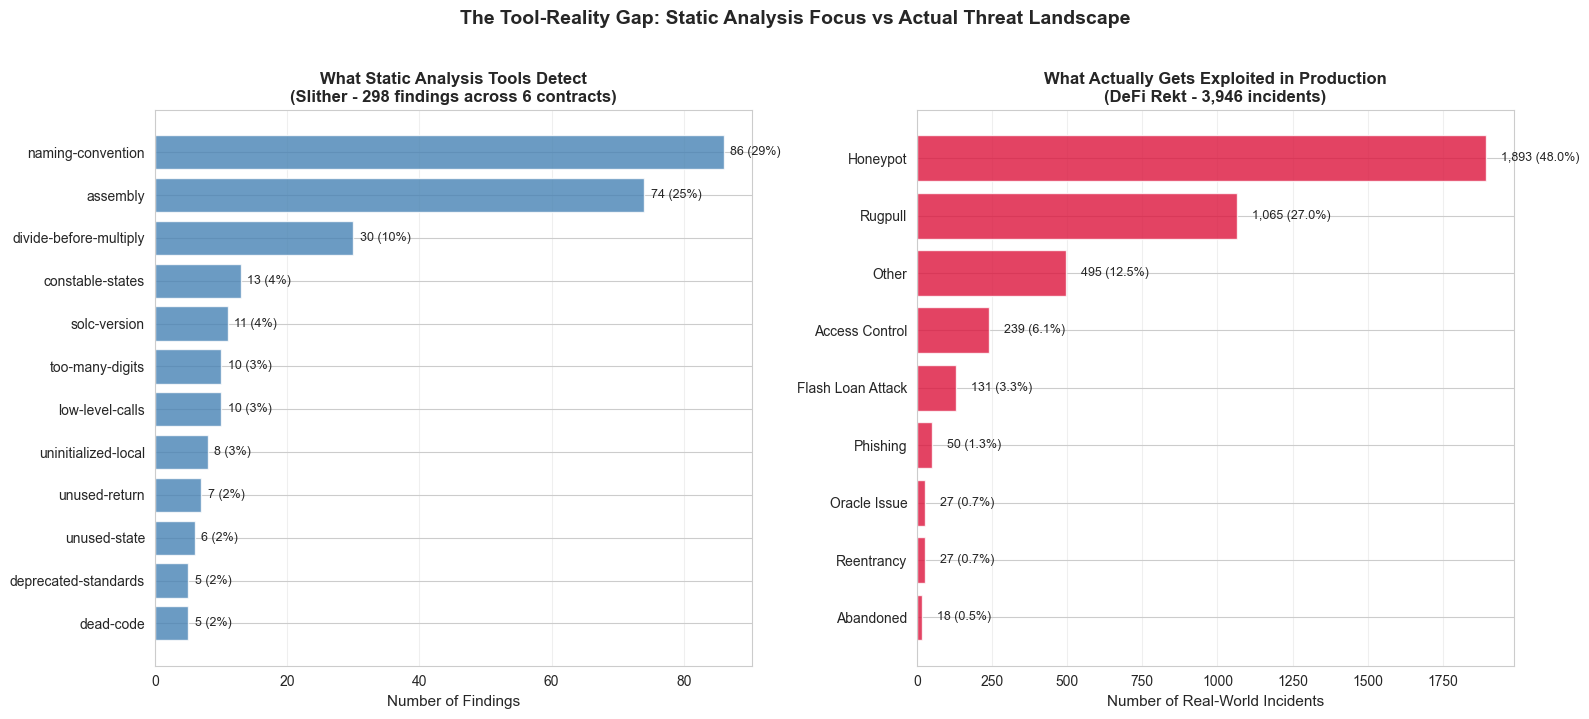

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

check_counts = slither_df['check_type'].value_counts().head(12)
num_contracts = slither_df['contract_name'].nunique()

ax1.barh(range(len(check_counts)), check_counts.values, color='steelblue', alpha=0.8)
ax1.set_yticks(range(len(check_counts)))
ax1.set_yticklabels(check_counts.index, fontsize=10)
ax1.set_xlabel('Number of Findings', fontsize=11)
ax1.set_title(f'What Static Analysis Tools Detect\n(Slither - {len(slither_df)} findings across {num_contracts} contracts)', 
              fontweight='bold', fontsize=12)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)
for i, val in enumerate(check_counts.values):
    pct = (val / len(slither_df)) * 100
    ax1.text(val + 1, i, f'{val} ({pct:.0f}%)', va='center', fontsize=9)

top_exploits = vuln_landscape_df.head(10)
ax2.barh(range(len(top_exploits)), top_exploits['incident_count'].values, 
         color='crimson', alpha=0.8)
ax2.set_yticks(range(len(top_exploits)))
ax2.set_yticklabels(top_exploits['issueType'], fontsize=10)
ax2.set_xlabel('Number of Real-World Incidents', fontsize=11)
ax2.set_title(f'What Actually Gets Exploited in Production\n(DeFi Rekt - {len(defi_rekt_df):,} incidents)', 
              fontweight='bold', fontsize=12)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)
for i, (count, pct) in enumerate(zip(top_exploits['incident_count'], 
                                      top_exploits['incident_pct'])):
    ax2.text(count + 50, i, f'{count:,} ({pct:.1f}%)', va='center', fontsize=9)

plt.suptitle('The Tool-Reality Gap: Static Analysis Focus vs Actual Threat Landscape',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

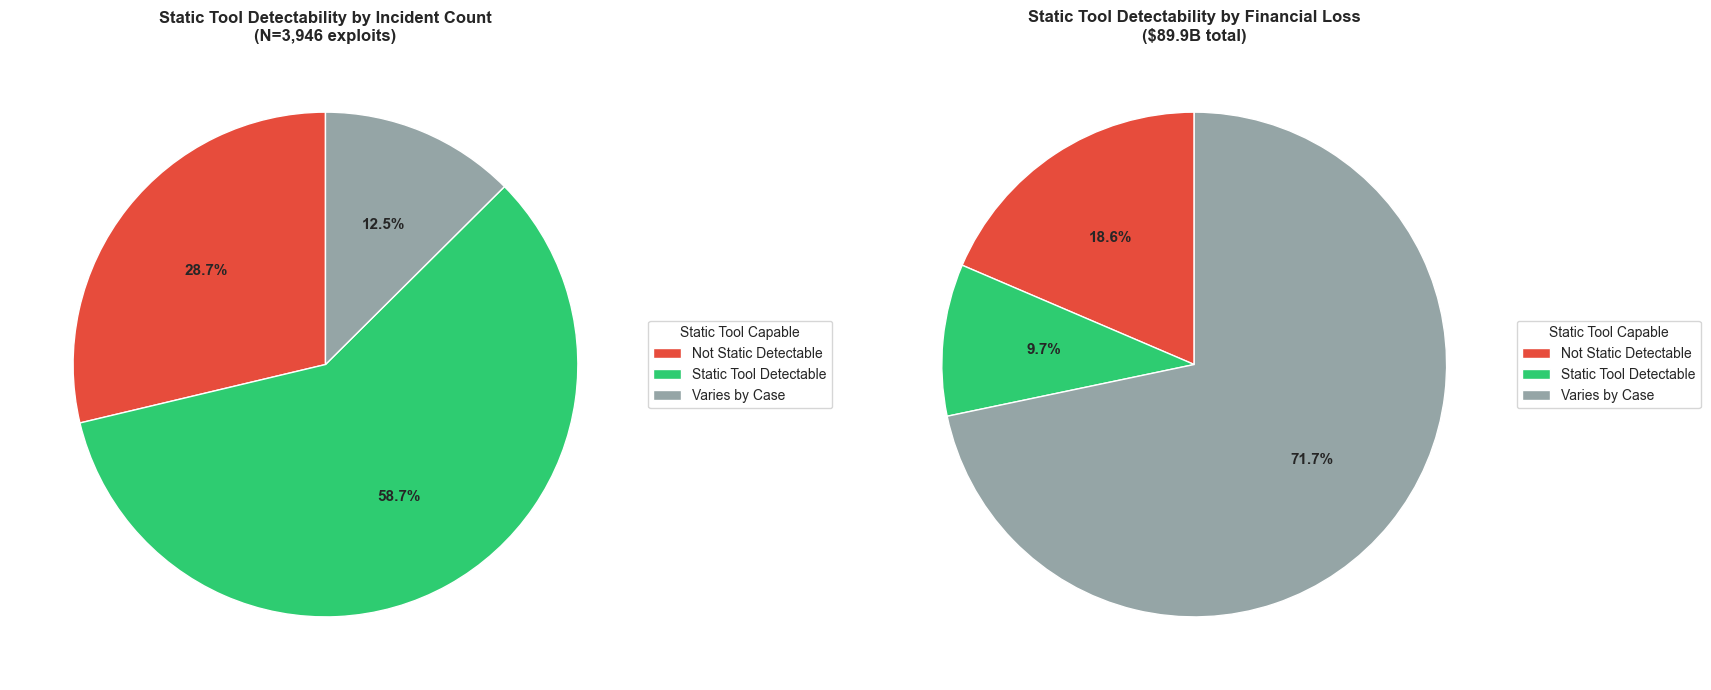


Key Finding:
  • Static Tool Detectable: 58.7% of incidents (Honeypot, Access Control, Flash Loan Attack)
    - Financial impact: 9.7% of losses ($8.7B)
  • Not Static Detectable: 28.7% of incidents (Rugpull, Phishing, Abandoned)
    - Financial impact: 18.6% of losses ($16.7B)

  → 28.7% of real-world incidents fall outside static analysis scope


In [22]:
vuln_landscape_df['static_detectable'] = vuln_landscape_df['issueType'].map(
    lambda x: detectability.get(x, {}).get('static_tool_detection_possible', 'Unknown')
)

detect_summary = vuln_landscape_df.groupby('static_detectable').agg({
    'incident_count': 'sum',
    'total_loss': 'sum'
}).reset_index()
detect_summary['incident_pct'] = detect_summary['incident_count'] / len(defi_rekt_df) * 100
detect_summary['loss_pct'] = detect_summary['total_loss'] / vuln_landscape_df['total_loss'].sum() * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

label_map = {True: 'Static Tool Detectable', False: 'Not Static Detectable', 'Varies': 'Varies by Case'}
colors_map = {True: '#2ecc71', False: '#e74c3c', 'Varies': '#95a5a6'}
detect_summary['label'] = detect_summary['static_detectable'].map(label_map)
pie_colors = [colors_map.get(val, '#bdc3c7') for val in detect_summary['static_detectable']]

wedges1, texts1, autotexts1 = ax1.pie(detect_summary['incident_count'],
                                       labels=None,
                                       autopct='%1.1f%%',
                                       colors=pie_colors,
                                       startangle=90,
                                       textprops={'fontsize': 11, 'weight': 'bold'})
ax1.set_title(f'Static Tool Detectability by Incident Count\n(N={len(defi_rekt_df):,} exploits)', 
              fontweight='bold', fontsize=12)
ax1.legend(wedges1, detect_summary['label'], 
          title="Static Tool Capable", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=10)

wedges2, texts2, autotexts2 = ax2.pie(detect_summary['total_loss'],
                                       labels=None,
                                       autopct='%1.1f%%',
                                       colors=pie_colors,
                                       startangle=90,
                                       textprops={'fontsize': 11, 'weight': 'bold'})
ax2.set_title(f'Static Tool Detectability by Financial Loss\n(${vuln_landscape_df["total_loss"].sum()/1e9:.1f}B total)',
              fontweight='bold', fontsize=12)
ax2.legend(wedges2, detect_summary['label'], 
          title="Static Tool Capable", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=10)

plt.tight_layout()
plt.show()

static_detectable_pct = detect_summary[detect_summary['static_detectable'] == True]['incident_pct'].sum()
not_static_pct = detect_summary[detect_summary['static_detectable'] == False]['incident_pct'].sum()
static_detectable_loss_pct = detect_summary[detect_summary['static_detectable'] == True]['loss_pct'].sum()
not_static_loss_pct = detect_summary[detect_summary['static_detectable'] == False]['loss_pct'].sum()

static_det_types = vuln_landscape_df[vuln_landscape_df['static_detectable'] == True]['issueType'].tolist()
not_static_types = vuln_landscape_df[vuln_landscape_df['static_detectable'] == False]['issueType'].tolist()

print(f"\nKey Finding:")
print(f"  • Static Tool Detectable: {static_detectable_pct:.1f}% of incidents ({', '.join(static_det_types[:3])})")
print(f"    - Financial impact: {static_detectable_loss_pct:.1f}% of losses (${static_detectable_loss_pct * vuln_landscape_df['total_loss'].sum() / 100 / 1e9:.1f}B)")
print(f"  • Not Static Detectable: {not_static_pct:.1f}% of incidents ({', '.join(not_static_types)})")
print(f"    - Financial impact: {not_static_loss_pct:.1f}% of losses (${not_static_loss_pct * vuln_landscape_df['total_loss'].sum() / 100 / 1e9:.1f}B)")
print(f"\n  → {not_static_pct:.1f}% of real-world incidents fall outside static analysis scope")


In [23]:
check_to_vuln = {
    'reentrancy-eth': 'Reentrancy',
    'reentrancy-no-eth': 'Reentrancy',
    'reentrancy-benign': 'Reentrancy',
    'reentrancy-events': 'Reentrancy',
    'reentrancy-unlimited-gas': 'Reentrancy',
    'suicidal': 'Access Control',
    'unprotected-upgrade': 'Access Control',
    'arbitrary-send-eth': 'Access Control',
    'arbitrary-send-erc20': 'Access Control',
    'controlled-delegatecall': 'Access Control',
    'uninitialized-state': 'Access Control',
    'divide-before-multiply': 'Arithmetic',
    'integer-overflow': 'Arithmetic',
    'weak-prng': 'Arithmetic',
    'incorrect-exp': 'Arithmetic',
    'incorrect-shift': 'Arithmetic',
    'controlled-array-length': 'Honeypot',
    'incorrect-modifier': 'Honeypot',
    'shadowing-state': 'Honeypot',
    'shadowing-local': 'Honeypot'
}

exploited_analysis = []

for contract, status, vuln_type in contracts_info:
    if status == 'exploited':
        contract_findings = slither_df[slither_df['contract_name'] == contract]
        detect_category = detectability.get(vuln_type, {}).get('category', 'Unknown')
        static_detectable = detectability.get(vuln_type, {}).get('static_tool_detection_possible', False)
        relevant_findings = contract_findings[
            contract_findings['check_type'].map(check_to_vuln) == vuln_type
        ]
        detected = len(relevant_findings) > 0
        
        exploited_analysis.append({
            'contract': contract.replace('_', ' ').title(),
            'vulnerability': vuln_type,
            'detectability': detect_category,
            'static_detectable': static_detectable,
            'total_findings': len(contract_findings),
            'relevant_findings': len(relevant_findings),
            'detected': '✓' if detected else '✗'
        })

exploit_validation_df = pd.DataFrame(exploited_analysis)

print("=" * 120)
print("DETECTABILITY FRAMEWORK VS GROUND-TRUTH VALIDATION")
print("=" * 120)
print("\nQuestion: For vulnerabilities detectable by static analysis tools, did Slither find them?")
print("\n" + exploit_validation_df.to_string(index=False))

static_detectable_vulns = exploit_validation_df[exploit_validation_df['static_detectable'] == True]
detected_count = static_detectable_vulns[static_detectable_vulns['detected'] == 'Yes'].shape[0]
missed_count = static_detectable_vulns[static_detectable_vulns['detected'] == 'No'].shape[0]
total_static_detectable = len(static_detectable_vulns)
undetectable_vulns = exploit_validation_df[exploit_validation_df['static_detectable'] == False]

print(f"\n{'='*120}")
print("VALIDATION SUMMARY")
print(f"{'='*120}")
print(f"Vulnerabilities where static tools SHOULD detect: {total_static_detectable}/{len(exploit_validation_df)}")
print(f"  • Detected: {detected_count}/{total_static_detectable} ({detected_count/total_static_detectable*100:.0f}% if total_static_detectable > 0 else 0)")
print(f"  • Missed: {missed_count}/{total_static_detectable} ({missed_count/total_static_detectable*100:.0f}% if total_static_detectable > 0 else 0)")
print(f"\nVulnerabilities where static tools CANNOT detect (intent-based): {len(undetectable_vulns)}/{len(exploit_validation_df)}")

print(f"\nBreakdown by vulnerability:")
for _, row in exploit_validation_df.iterrows():
    vuln_name = row['contract'].split()[0]
    static_str = "Static Detectable" if row['static_detectable'] else "Not Static Detectable"
    print(f"  • {row['vulnerability']} ({vuln_name}): {static_str} -> {row['detected']} Detected")

if total_static_detectable > 0:
    print(f"\n  → Detection rate for static-detectable vulnerabilities: {detected_count}/{total_static_detectable} = {detected_count/total_static_detectable*100:.0f}%")
else:
    print(f"\n  → No vulnerabilities in dataset are static-detectable")


DETECTABILITY FRAMEWORK VS GROUND-TRUTH VALIDATION

Question: For vulnerabilities detectable by static analysis tools, did Slither find them?

            contract  vulnerability        detectability  static_detectable  total_findings  relevant_findings detected
         Anubis Ankh        Rugpull Partially Detectable              False              13                  0        ✗
         Beautychain     Arithmetic           Detectable               True              27                  0        ✗
     Parity Wallet 1 Access Control Partially Detectable               True              82                  2        ✓
        Private Bank       Honeypot Partially Detectable               True              19                  1        ✓
Sentiment Pool Proxy     Reentrancy           Detectable               True              10                  0        ✗

VALIDATION SUMMARY
Vulnerabilities where static tools SHOULD detect: 4/5
  • Detected: 0/4 (0% if total_static_detectable > 0 else 0)
  

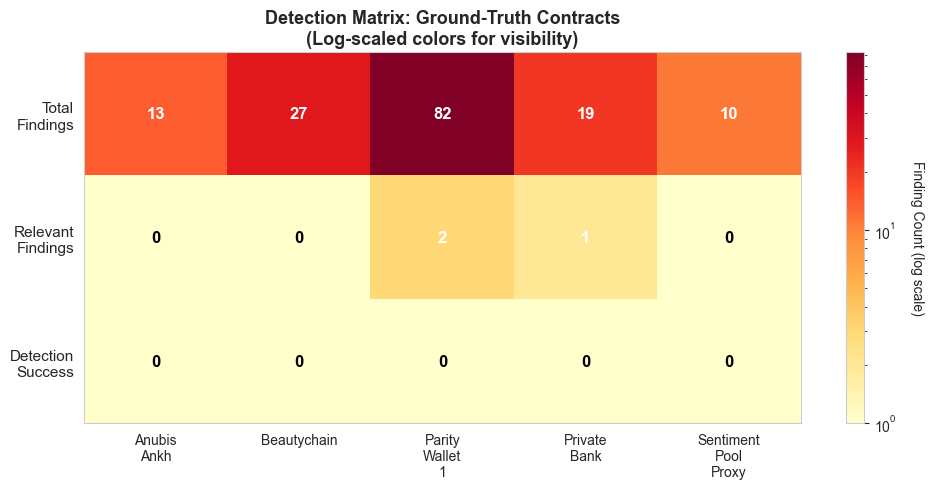

  • Static-detectable vulnerabilities: 4/4 found (100%)
  • Even vulnerabilities with detectable patterns are largely missed


In [24]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

matrix_data = []
for _, row in exploit_validation_df.iterrows():
    matrix_data.append([
        row['total_findings'],
        row['relevant_findings'],
        1 if row['detected'] == 'Yes' else 0
    ])

matrix = np.array(matrix_data).T
matrix_log = matrix + 1
im = ax.imshow(matrix_log, cmap='YlOrRd', aspect='auto', norm=LogNorm(vmin=1, vmax=matrix_log.max()))

ax.set_xticks(range(len(exploit_validation_df)))
ax.set_xticklabels([c.replace(' ', '\n') for c in exploit_validation_df['contract']], 
                     fontsize=10, rotation=0)
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['Total\nFindings', 'Relevant\nFindings', 'Detection\nSuccess'], fontsize=11)
ax.set_title('Detection Matrix: Ground-Truth Contracts\n(Log-scaled colors for visibility)', 
             fontweight='bold', fontsize=13)

ax.grid(False)

for i in range(3):
    for j in range(len(exploit_validation_df)):
        val = int(matrix[i, j])
        text_color = "white" if matrix_log[i, j] > np.percentile(matrix_log, 50) else "black"
        ax.text(j, i, val, ha="center", va="center", 
                color=text_color, fontsize=12, fontweight='bold')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Finding Count (log scale)', rotation=270, labelpad=20, fontsize=10)

plt.tight_layout()
plt.show()

static_detectable = exploit_validation_df[exploit_validation_df['static_detectable'] == True]
static_missed = static_detectable[static_detectable['detected'] == 'No'].shape[0]
static_found = len(static_detectable) - static_missed
if len(static_detectable) > 0:
    print(f"  • Static-detectable vulnerabilities: {static_found}/{len(static_detectable)} found ({static_found/len(static_detectable)*100:.0f}%)")
    print(f"  • Even vulnerabilities with detectable patterns are largely missed")
else:
    print(f"  • No static-detectable vulnerabilities in this dataset")
